## Length of the code {-}
No restriction

**Delete this section from the report, when using this template.** 

In [1]:
# loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [2]:
# loading data
games = pd.read_csv("data_raw/game.csv")
team_info = pd.read_csv("data_raw/team_info.csv")

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Tess Wagner*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

For this project, our response variable is whether a team made the playoffs or not. In the original dataset, the response variable was not clearly visable. Therefore, we cannot show the associations between the possible predictor variables and reponse variables until after the data has been cleaned.

In [29]:
games.columns

Index(['game_id', 'season', 'type', 'date_time_GMT', 'away_team_id',
       'home_team_id', 'away_goals', 'home_goals', 'outcome',
       'home_rink_side_start', 'venue', 'venue_link', 'venue_time_zone_id',
       'venue_time_zone_offset', 'venue_time_zone_tz'],
      dtype='object')

In [27]:
print("This dataset has data for", games.shape[0], "NHL games spanning from the", games.loc[games.season.argmin(), 'season'], 'season to the', games.loc[games.season.argmax(), 'season'], 'season.')

This dataset has data for 26305 NHL games spanning from the 20002001 season to the 20192020 season.


In [44]:
games.isna().sum()

game_id                      0
season                       0
type                         0
date_time_GMT                0
away_team_id                 0
home_team_id                 0
away_goals                   0
home_goals                   0
outcome                      0
home_rink_side_start      1196
venue                        0
venue_link                   0
venue_time_zone_id           0
venue_time_zone_offset       0
venue_time_zone_tz           0
dtype: int64

`home_rink_side_start` is the only column with missing values.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 [Text(0, 0, '20162017'),
  Text(1, 0, '20172018'),
  Text(2, 0, '20152016'),
  Text(3, 0, '20142015'),
  Text(4, 0, '20132014'),
  Text(5, 0, '20122013'),
  Text(6, 0, '20112012'),
  Text(7, 0, '20102011'),
  Text(8, 0, '20092010'),
  Text(9, 0, '20082009'),
  Text(10, 0, '20072008'),
  Text(11, 0, '20062007'),
  Text(12, 0, '20022003'),
  Text(13, 0, '20032004'),
  Text(14, 0, '20052006'),
  Text(15, 0, '20002001'),
  Text(16, 0, '20012002'),
  Text(17, 0, '20192020'),
  Text(18, 0, '20182019')])

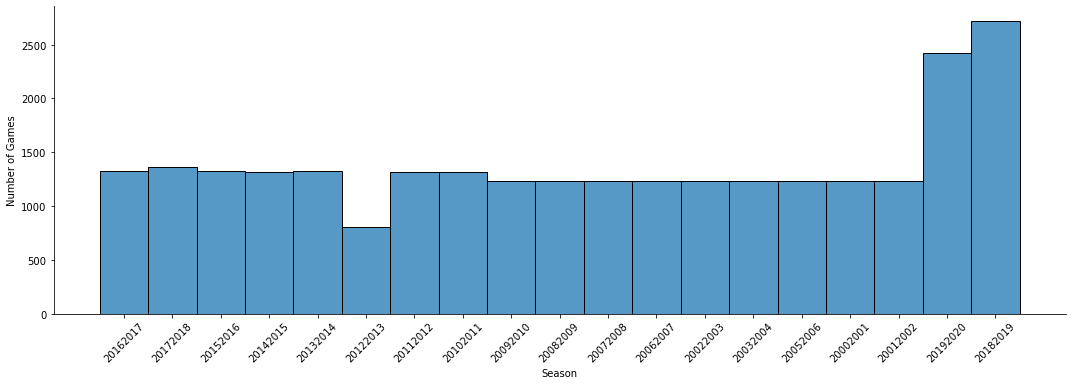

In [42]:
x = games.season.apply(lambda x:str(x))

#plt.figure(figsize=(30,5))
z = sns.displot(data = games, x = x, kind = 'hist', aspect = 3)
z.set_axis_labels("Season", "Number of Games")
plt.xticks(rotation=45)

We want to use game data from seasons where there is data for the full 82 games played by each team. After checking the 20122013 data, we found that a large chunk of game data was missing. For the 20182019 and 20192020 seasons, many of the games were duplicated.

In [28]:
#...Distribution of continuous variables...#

In [4]:
#...Distribution of categorical variables...#

In [5]:
#...Association of the response with the predictors...#

### Data cleaning
*By Tess Wagner*

From the data quality check we realized that:

1. We needed to keep data only from the games of the ten seasons we wanted to use to build our model. We are keeping data from the 2007-08 season through the 2017-18 season. (We are not keeping data from 
2. We can drop the columns in `game.csv` and `team_info.csv` that we know we will not use (`venue_link`, `franchiseId`, `abbreviation`, `link`).
3. To get a full team name, we combined the variables `teamName` and `shortName` (and fixed the NY team names).
4. To make it easier to identify which team played which games, we replaced `team_id` (a numerical value) in the game dataset with `team_name` from the team info dataset.
5. We separated the games dataset into regular season games so that we do not factor playoff game data into our model. 
6. We dropped `team_id` from the team names dataset as it is no longer useful.
7. Next, we wanted to get datasets for each season with each team's stats. We began by creating new columns with away and home wins and away and home losses. 
8. Then we separated the regular season game data into separate dataframes - one for each season. We also created the same amount of dataframes with just team names so that we can later fill in the season statistics data into these mostly empty dataframes.
9. After that, we created some functions to fill in the team season statistics dataframes with predictors that we might be interested in.
10. Then we got lists of all of the teams that made the playoffs in each season and added the column `made_playoffs` to designate whether a team made playoffs that season.


The code below implements the above cleaning.

In [16]:
# importing the datasets
games = pd.read_csv("data_raw/game.csv")
team_info = pd.read_csv("data_raw/team_info.csv")

In [17]:
# filtering data from the 20072008 through the 20172018 seasons
games = games[(games['season'] >= 20072008) & (games['season'] <= 20172018)].sort_values('season')

In [18]:
# dropping columns that we know we wont use in our model
games.drop('venue_link', axis = 1, inplace = True)
team_info.drop(['franchiseId', 'abbreviation', 'link'], axis = 1, inplace = True)

In [19]:
# combining team city and team nickname to create full team name
team_info['team_name'] = team_info['shortName'] + ' ' + team_info['teamName']
team_info.replace(['NY Rangers Rangers', 'NY Islanders Islanders'], ['New York Rangers', 'New York Islanders'], inplace = True)
team_info.drop(['shortName', 'teamName'], axis = 1, inplace = True)

In [20]:
# replacing team id numbers with full team names
list_of_ids = team_info['team_id'].values

for Id in list_of_ids:
    games.away_team_id.replace(Id, team_info[team_info['team_id'] == Id]['team_name'].values[0], inplace = True)
    games.home_team_id.replace(Id, team_info[team_info['team_id'] == Id]['team_name'].values[0], inplace = True)

In [30]:
# getting dataframe with only regular season games
regular_season_games = games[games['type'] == 'R']

In [26]:
# getting rid of team id in team names dataset
team_names = team_info.drop('team_id', axis = 1)

In [31]:
# adding columns to organize game outcomes 
regular_season_games['away_wins'] = regular_season_games.loc[regular_season_games.outcome.isin(['away win OT', 'away win REG']), 'away_team_id']
regular_season_games['home_wins'] = regular_season_games.loc[regular_season_games.outcome.isin(['home win OT', 'home win REG']), 'home_team_id']
regular_season_games['away_losses'] = regular_season_games.loc[regular_season_games.outcome.isin(['home win OT', 'home win REG']), 'away_team_id']
regular_season_games['home_losses'] = regular_season_games.loc[regular_season_games.outcome.isin(['away win OT', 'away win REG']), 'home_team_id']

C:\Users\csky2\AppData\Local\Temp\ipykernel_85908\1972072309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_season_games['away_wins'] = regular_season_games.loc[regular_season_games.outcome.isin(['away win OT', 'away win REG']), 'away_team_id']
C:\Users\csky2\AppData\Local\Temp\ipykernel_85908\1972072309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regular_season_games['home_wins'] = regular_season_games.loc[regular_season_games.outcome.isin(['home win OT', 'home win REG']), 'home_team_i

In [32]:
# separating the data by season
games_07_08 = regular_season_games[regular_season_games['season'] == 20072008]
games_08_09 = regular_season_games[regular_season_games['season'] == 20082009]
games_09_10 = regular_season_games[regular_season_games['season'] == 20092010]
games_10_11 = regular_season_games[regular_season_games['season'] == 20102011]
games_11_12 = regular_season_games[regular_season_games['season'] == 20112012]
games_13_14 = regular_season_games[regular_season_games['season'] == 20132014]
games_14_15 = regular_season_games[regular_season_games['season'] == 20142015]
games_15_16 = regular_season_games[regular_season_games['season'] == 20152016]
games_16_17 = regular_season_games[regular_season_games['season'] == 20162017]
games_17_18 = regular_season_games[regular_season_games['season'] == 20172018]

In [34]:
# creating dataframes with only team names for each season
teams_07_08 = team_names.copy()
teams_08_09 = team_names.copy()
teams_09_10 = team_names.copy()
teams_10_11 = team_names.copy()
teams_11_12 = team_names.copy()
teams_13_14 = team_names.copy()
teams_14_15 = team_names.copy()
teams_15_16 = team_names.copy()
teams_16_17 = team_names.copy()
teams_17_18 = team_names.copy()

In [42]:
# defining functions
list_of_conditions = ['away_wins', 'home_wins', 'away_losses', 'home_losses']
list_of_teams = team_names.team_name.values

# function to add number of away/home wins/losses to dataframes with team info by season
def get_counts(games_df, team_df):
    for condition in list_of_conditions:
        for team in list_of_teams: 
            team_df.loc[team_df.team_name.isin([team]), condition] = len(games_df[games_df[condition] == team])

# helper function to get number of goals scored per team per season
def _total_goals_scored(team, games_df):
    return games_df.loc[games_df.away_team_id.isin([team]), 'away_goals'].sum() + games_df.loc[games_df.home_team_id.isin([team]), 'home_goals'].sum()

# helper function to get number of goals against each team per season
def _total_goals_against(team, games_df):
    return games_df.loc[games_df.away_team_id.isin([team]), 'home_goals'].sum() + games_df.loc[games_df.home_team_id.isin([team]), 'away_goals'].sum()

# function to add number of goals scored and goals against to dataframes with team info by season
def get_goal_counts(games_df, team_df):
    for team in list_of_teams:
        team_df.loc[team_df.team_name.isin([team]), 'total_goals_scored'] = _total_goals_scored(team, games_df)
        team_df.loc[team_df.team_name.isin([team]), 'total_goals_against'] = _total_goals_against(team, games_df)
        
# function to calculate/add the goal differential for each team per season
def get_goal_diff(games_df, team_df):
    for team in list_of_teams:
        team_df.loc[team_df.team_name.isin([team]), 'goal_diff'] = (team_df.loc[team_df.team_name.isin([team]), 'total_goals_scored']) - (team_df.loc[team_df.team_name.isin([team]), 'total_goals_against'])
        
# function to add a column specifying whether a team made the playoffs
def make_playoff_team(list_of_teams, team_df):
    team_df.made_playoffs.fillna(value = 'No', inplace = True)
    for team in list_of_teams: 
        team_df.loc[team_df.team_name.isin([team]), 'made_playoffs'] = 'Yes'

In [37]:
# executing the functions
get_counts(games_07_08, teams_07_08)
get_counts(games_08_09, teams_08_09)
get_counts(games_09_10, teams_09_10)
get_counts(games_10_11, teams_10_11)
get_counts(games_11_12, teams_11_12)
get_counts(games_13_14, teams_13_14)
get_counts(games_14_15, teams_14_15)
get_counts(games_15_16, teams_15_16)
get_counts(games_16_17, teams_16_17)
get_counts(games_17_18, teams_17_18)

get_goal_counts(games_07_08, teams_07_08)
get_goal_counts(games_08_09, teams_08_09)
get_goal_counts(games_09_10, teams_09_10)
get_goal_counts(games_10_11, teams_10_11)
get_goal_counts(games_11_12, teams_11_12)
get_goal_counts(games_13_14, teams_13_14)
get_goal_counts(games_14_15, teams_14_15)
get_goal_counts(games_15_16, teams_15_16)
get_goal_counts(games_16_17, teams_16_17)
get_goal_counts(games_17_18, teams_17_18)

get_goal_diff(games_07_08, teams_07_08)
get_goal_diff(games_08_09, teams_08_09)
get_goal_diff(games_09_10, teams_09_10)
get_goal_diff(games_10_11, teams_10_11)
get_goal_diff(games_11_12, teams_11_12)
get_goal_diff(games_13_14, teams_13_14)
get_goal_diff(games_14_15, teams_14_15)
get_goal_diff(games_15_16, teams_15_16)
get_goal_diff(games_16_17, teams_16_17)
get_goal_diff(games_17_18, teams_17_18)

In [39]:
playoffs_07_08 = ['Anaheim Ducks','Boston Bruins','Calgary Flames','Colorado Avalanche','Dallas Stars','Detroit Red Wings','Minnesota Wild','Montreal Canadiens','Nashville Predators','New Jersey Devils','New York Rangers','Ottawa Senators','Philadelphia Flyers','Pittsburgh Penguins','San Jose Sharks','Washington Capitals']
playoffs_08_09 = ['Pittsburgh Penguins','Detroit Red Wings','Chicago Blackhawks','Carolina Hurricanes','Boston Bruins','Anaheim Ducks','Washington Capitals','Vancouver Canucks','New Jersey Devils','New York Rangers','Philadelphia Flyers','Calgary Flames','San Jose Sharks','St Louis Blues','Montreal Canadiens','Columbus Blue Jackets']
playoffs_09_10 = ['Chicago Blackhawks','Philadelphia Flyers','Montreal Canadiens','San Jose Sharks','Pittsburgh Penguins','Boston Bruins','Vancouver Canucks','Detroit Red Wings','Phoenix Coyotes','Washington Capitals','Ottawa Senators','Colorado Avalanche','Buffalo Sabres','Los Angeles Kings','Nashville Predators','New Jersey Devils']
playoffs_10_11 = ['San Jose Sharks','Boston Bruins','Vancouver Canucks','Nashville Predators','Washington Capitals','Tampa Bay Lightning','Philadelphia Flyers','Pittsburgh Penguins','Chicago Blackhawks','Buffalo Sabres','Detroit Red Wings','Montreal Canadiens','Anaheim Ducks','Los Angeles Kings','New York Rangers','Phoenix Coyotes']
playoffs_11_12 = ['Los Angeles Kings','New Jersey Devils','New York Rangers','Phoenix Coyotes','Washington Capitals','Nashville Predators','Philadelphia Flyers','St Louis Blues','Boston Bruins','Ottawa Senators','Florida Panthers','Pittsburgh Penguins','Chicago Blackhawks','Detroit Red Wings','Vancouver Canucks','San Jose Sharks']
playoffs_13_14 = ['Los Angeles Kings','New York Rangers','Chicago Blackhawks','Montreal Canadiens','Boston Bruins','Anaheim Ducks','Pittsburgh Penguins','Minnesota Wild','Colorado Avalanche','Philadelphia Flyers','San Jose Sharks','Dallas Stars','Columbus Blue Jackets','St Louis Blues','Detroit Red Wings','Tampa Bay Lightning']
playoffs_14_15 = ['Chicago Blackhawks','Tampa Bay Lightning','Anaheim Ducks','New York Rangers','Washington Capitals','Montreal Canadiens','Calgary Flames','Minnesota Wild','New York Islanders','Detroit Red Wings','Ottawa Senators','Nashville Predators','Vancouver Canucks','St Louis Blues','Pittsburgh Penguins','Winnipeg Jets']
playoffs_15_16 = ['Pittsburgh Penguins','San Jose Sharks','Tampa Bay Lightning','St Louis Blues','Dallas Stars','Nashville Predators','Washington Capitals','New York Islanders','Chicago Blackhawks','Anaheim Ducks','Minnesota Wild','Florida Panthers','Philadelphia Flyers','New York Rangers','Detroit Red Wings','Los Angeles Kings']
playoffs_16_17 = ['Pittsburgh Penguins','Nashville Predators','Ottawa Senators','Anaheim Ducks','Edmonton Oilers','Washington Capitals','St Louis Blues','New York Rangers','San Jose Sharks','Montreal Canadiens','Boston Bruins','Toronto Maple Leafs','Minnesota Wild','Columbus Blue Jackets','Calgary Flames','Chicago Blackhawks']
playoffs_17_18 = ['Washington Capitals','Vegas Golden Knights','Tampa Bay Lightning','Winnipeg Jets','Nashville Predators','San Jose Sharks','Pittsburgh Penguins','Boston Bruins','Toronto Maple Leafs','Philadelphia Flyers','Colorado Avalanche','Columbus Blue Jackets','Minnesota Wild','New Jersey Devils','Los Angeles Kings','Anaheim Ducks']

In [43]:
make_playoff_team(playoffs_07_08, teams_07_08)
make_playoff_team(playoffs_08_09, teams_08_09)
make_playoff_team(playoffs_09_10, teams_09_10)
make_playoff_team(playoffs_10_11, teams_10_11)
make_playoff_team(playoffs_11_12, teams_11_12)
make_playoff_team(playoffs_13_14, teams_13_14)
make_playoff_team(playoffs_14_15, teams_14_15)
make_playoff_team(playoffs_15_16, teams_15_16)
make_playoff_team(playoffs_16_17, teams_16_17)
make_playoff_team(playoffs_17_18, teams_17_18)

### Data preparation
*By Sankaranarayanan Balasubramanian and Chun-Li*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [3]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [ ]:
######-----------Shuffling the dataset for K-fold------------#########

In [ ]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [ ]:
szn_78 = pd.read_csv('teams_07_08.csv')
szn_89 = pd.read_csv('teams_08_09.csv')
szn_910 = pd.read_csv('teams_09_10.csv')
szn_1011 = pd.read_csv('teams_10_11.csv')
szn_1112 = pd.read_csv('teams_11_12.csv')
szn_1314 = pd.read_csv('teams_13_14.csv')
szn_1415 = pd.read_csv('teams_14_15.csv')
szn_1516 = pd.read_csv('teams_15_16.csv')
szn_1617 = pd.read_csv('teams_16_17.csv')
szn_1718 = pd.read_csv('teams_17_18.csv')

szn_lists = [szn_78, szn_89, szn_910, szn_1011, szn_1112, szn_1314, szn_1415, szn_1516, szn_1617, szn_1718]
full_szns = pd.concat(szn_lists, axis=0, ignore_index=True)
PO_teams = full_szns.loc[full_szns['made_playoffs']=="Yes"]
PO_teams['total_wins'] = PO_teams['home_wins'] + PO_teams['away_wins']
PO_teams.describe()

In [ ]:
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
playoff_dummies = pd.get_dummies(full_szns['made_playoffs'])
playoff_dummies['Yes']
playoff_dummies = pd.get_dummies(full_szns, prefix = ['made_playoffs'], columns = ['made_playoffs'])
model = smf.ols(formula = 'made_playoffs_Yes~away_wins+home_wins+away_losses+home_losses+total_goals_scored+total_goals_against', data = playoff_dummies).fit()
model.summary()   

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.